In [166]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import random
from generate_data import generate_Ls, generate_sylvester_data
from proximal_gradient_descent import (
    get_optimizer_oracles,
    proximal_accelerated_gradient,
    project_to_lower_with_positive_diag,
    warm_start
)
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, f1_score
from plotting_utilities import get_metrics, patternify_Ls, one_example_prs
import scanpy as sc
import igraph as ig
import xarray as xr
import pickle
import itertools

# Prevent Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

This dataset comes from the paper ["Hierarchical Differentiation of Myeloid Progenitors Is Encoded in the Transcription Factor Network"](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0022649).  It is a _synthetic_ scRNA-seq dataset, in which the a regulatory network was designed based on expert knowledge.  The dataset represents the diversification of hematopoetic progenitors into Erythrocytes, Megakaryocytes, Neutrophils, and Monocytes.

It is a good dataset to play with, as the genes have a known structure and the cells have a natural `pseudotemporal' structure that would ideally be captured by graphical methods.  However, the regulatory network they use is _not a DAG_!  There are regulatory feedback loops.  Because of this, and the fact that the dataset is non-Gaussian, make it somewhat 'out-of-distribution' for our method.  The fact that, as we will see, our method still performs well is a strong vote of confidence!

In [2]:
krum_data = sc.datasets.krumsiek11()
#krum_data.X /= krum_data.X.sum(axis=1).reshape(-1, 1)
krum_data.uns["cell_type_colors"] = ['#aaaaaa', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

/Users/baileyandrew/mambaforge/envs/Cartesian-LGAM/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


We can get a quick look at the diversification of blood cells via a PCA plot.

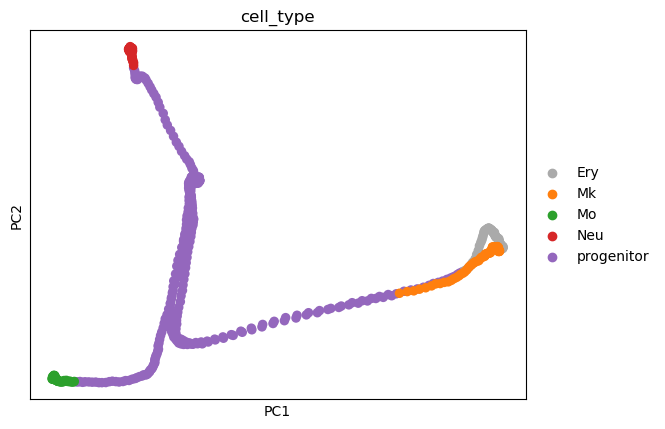

In [3]:
sc.pp.pca(krum_data)
sc.pl.pca(krum_data, color="cell_type")

We can also demonstrate non-Gaussianity:

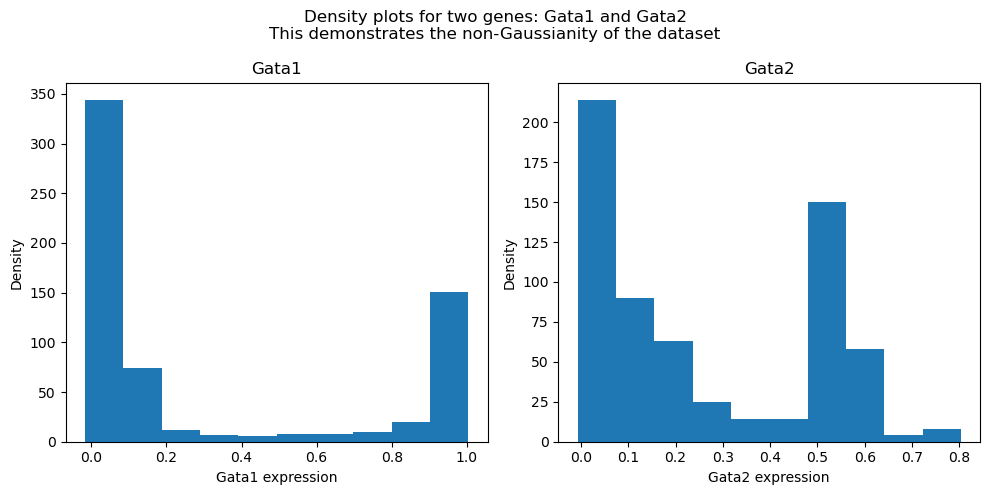

In [4]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

ax1.hist(krum_data.X[:, 1])
ax1.set_xlabel(f"{krum_data.var_names[1]} expression")
ax1.set_ylabel("Density")
ax1.set_title(f"{krum_data.var_names[1]}")

ax2.hist(krum_data.X[:, 0])
ax2.set_xlabel(f"{krum_data.var_names[0]} expression")
ax2.set_ylabel("Density")
ax2.set_title(f"{krum_data.var_names[0]}")

fig.suptitle("Density plots for two genes: Gata1 and Gata2\nThis demonstrates the non-Gaussianity of the dataset")
fig.tight_layout()
pass

## Determining the order of genes

In this section, we're determine the ordering of genes.  The first few codeblocks are 'busywork'; they're used to plot the ground truth gene graph.

### Plotting the ground truth gene graph

In [5]:
# Convention: (row i, col j): col j points to row i
coords = np.array(['Gata1', 'Gata2', 'SCL', 'Fog1', 'EKLF', 'Fli1', 'Cebpa', 'Pu.1', 'cJun', 'EgrNab', 'Gfi1'])
true_graph = xr.DataArray(np.zeros((11, 11), dtype=bool), coords=[coords, coords], dims=["to", "from"])

# Edges from Fog1
true_graph.loc["Gata2", "Fog1"] = True

# Edges from Gata2
true_graph.loc["Gata1", "Gata2"] = True
true_graph.loc["Pu.1", "Gata2"] = True

# Edges from Gata1
true_graph.loc["Fog1", "Gata1"] = True
true_graph.loc["Gata2", "Gata1"] = True
true_graph.loc["Pu.1", "Gata1"] = True
true_graph.loc["SCL", "Gata1"] = True
true_graph.loc["EKLF", "Gata1"] = True
true_graph.loc["Fli1", "Gata1"] = True

# Edges from Fli1
true_graph.loc["Gata1", "Fli1"] = True
true_graph.loc["EKLF", "Fli1"] = True

# Edges from EKLF
true_graph.loc["Fli1", "EKLF"] = True

# Edges from SCL
pass

# Edges from Pu.1
true_graph.loc["Gata1", "Pu.1"] = True
true_graph.loc["Gata2", "Pu.1"] = True
true_graph.loc["SCL", "Pu.1"] = True
true_graph.loc["cJun", "Pu.1"] = True
true_graph.loc["EgrNab", "Pu.1"] = True

# Edges from cJun
true_graph.loc["Pu.1", "cJun"] = True
true_graph.loc["EgrNab", "cJun"] = True

# Edges from EgrNab
true_graph.loc["Gfi1", "EgrNab"] = True

# Edges from Gfi1
true_graph.loc["EgrNab", "Gfi1"] = True
true_graph.loc["Pu.1", "Gfi1"] = True

# Edges from CEBPA
true_graph.loc["Pu.1", "Cebpa"] = True
true_graph.loc["Gfi1", "Cebpa"] = True

In [6]:
r1 = 1
r2 = 0
r3 = -1
r4 = -2

gene_layout_dict = {
    "Gata1": (0, 0),
    "Gata2": (1, 1),
    "SCL": (1, -1),
    "Fog1": (-2, 0.5),
    "EKLF": (-0.5, -2),
    "Fli1": (-2.5, -1),
    "Cebpa": (4.5, 1),
    "Pu.1": (2, 0),
    "cJun": (2.5, -1.5),
    "EgrNab": (5, -2),
    "Gfi1": (5.5, -1)
}


gene_layout = [
    gene_layout_dict[gene]
    for gene
    in ['Gata1', 'Gata2', 'SCL', 'Fog1', 'EKLF', 'Fli1', 'Cebpa', 'Pu.1', 'cJun', 'EgrNab', 'Gfi1']
]

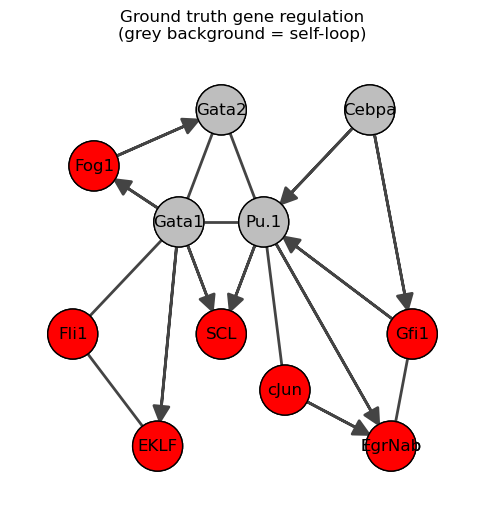

In [7]:
# It'll take a couple seconds to draw this graph.
fig, ax = plt.subplots(figsize=(6, 6))

random.seed(1)
gene_graph = ig.Graph.Weighted_Adjacency(true_graph.data.T)
gene_graph.vs["label"] = true_graph.coords["to"].data
gene_graph.vs["color"] = [
    'grey' if v in {'Gata1', 'Gata2', 'Pu.1', 'Cebpa'} else 'red'
    for v in gene_graph.vs['label']
]

# Annoyingly, igraph has no native support for plotting mixed graphs,
# so we'll plot the two 'undirected' and 'directed' graphs over each other!
mutual_pairs = set()
mutual_edges = []
oneway_edges = []

for e in gene_graph.es:
    s, t = e.tuple
    if gene_graph.are_adjacent(t, s) and (t, s) in gene_graph.get_edgelist():
        pair = frozenset((s, t))
        if pair not in mutual_pairs:
            mutual_pairs.add(pair)
            mutual_edges.append((s, t))  # store one direction only
    else:
        oneway_edges.append((s, t))

g_mutual = ig.Graph(directed=False)
g_mutual.add_vertices(gene_graph.vs["label"])
g_mutual.vs["label"] = gene_graph.vs["label"]
g_mutual.vs["color"] = gene_graph.vs["color"]
g_mutual.add_edges(mutual_edges)

g_oneway = ig.Graph(directed=True)
g_oneway.add_vertices(gene_graph.vs["label"])
g_oneway.vs["label"] = gene_graph.vs["label"]
g_oneway.vs["color"] = gene_graph.vs["color"]
g_oneway.add_edges(oneway_edges)

ig.plot(
    g_mutual,
    target=ax,
    vertex_size=50,
    layout=gene_layout
)

ig.plot(
    g_oneway,
    target=ax,
    vertex_size=50,
    layout=gene_layout
)

ax.set_title("Ground truth gene regulation\n(grey background = self-loop)")
pass

### Determining causal ordering

Since this graph was created using knowledge in the literature, we can reasonably assume to have some _a priori_ knowledge of what this graph will look like.  Here, we'll assume we know unidirectional edges and which genes have self-loops (i.e. which genes, if active, directly increase their own expression in a positive feedback loop).  In other words, we assume the following knowledge:

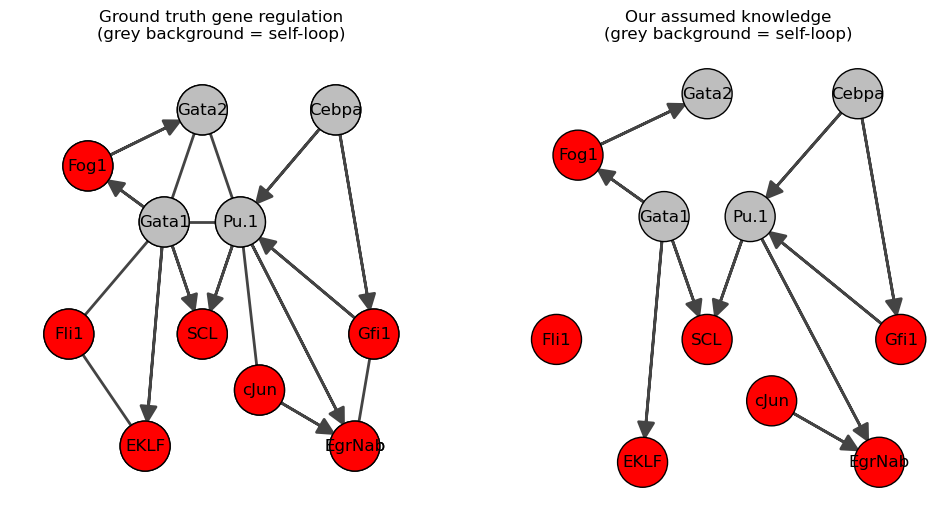

In [8]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)

random.seed(1)
gene_graph = ig.Graph.Weighted_Adjacency(true_graph.data.T)
gene_graph.vs["label"] = true_graph.coords["to"].data
gene_graph.vs["color"] = [
    'grey' if v in {'Gata1', 'Gata2', 'Pu.1', 'Cebpa'} else 'red'
    for v in gene_graph.vs['label']
]

# Annoyingly, igraph has no native support for plotting mixed graphs,
# so we'll plot the two 'undirected' and 'directed' graphs over each other!
mutual_pairs = set()
mutual_edges = []
oneway_edges = []

for e in gene_graph.es:
    s, t = e.tuple
    if gene_graph.are_adjacent(t, s) and (t, s) in gene_graph.get_edgelist():
        pair = frozenset((s, t))
        if pair not in mutual_pairs:
            mutual_pairs.add(pair)
            mutual_edges.append((s, t))  # store one direction only
    else:
        oneway_edges.append((s, t))

g_mutual = ig.Graph(directed=False)
g_mutual.add_vertices(gene_graph.vs["label"])
g_mutual.vs["label"] = gene_graph.vs["label"]
g_mutual.vs["color"] = gene_graph.vs["color"]
g_mutual.add_edges(mutual_edges)

g_oneway = ig.Graph(directed=True)
g_oneway.add_vertices(gene_graph.vs["label"])
g_oneway.vs["label"] = gene_graph.vs["label"]
g_oneway.vs["color"] = gene_graph.vs["color"]
g_oneway.add_edges(oneway_edges)

ig.plot(
    g_mutual,
    target=ax1,
    vertex_size=50,
    layout=gene_layout
)

ig.plot(
    g_oneway,
    target=ax1,
    vertex_size=50,
    layout=gene_layout
)

ig.plot(
    g_oneway,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Ground truth gene regulation\n(grey background = self-loop)")
ax2.set_title("Our assumed knowledge\n(grey background = self-loop)")
pass

For example, these edges can be sourced to the following papers: (TODO)

From this knowledge, we can construct a partial temporal ordering:

```
Gata1 > Fog1 > Gata2
Gata1 > EKLF
Gata1, Pu.1 > SCL
Cebpa > Gfi1 > Pu.1 > EgrNab
cJun > EgrNab
```

Since our method requires the full ordering to be known, we need some method of estimating the remaining information.  Note that genes that occur later causally will have larger variance than those that occur before, subject to certain assumptions (see our paper for details).  We would also expect genes with self-loops to have larger variance than normally expected.  This leads us to the following 3 criteria for determining the order, listed in order of importance:

1) If the ordering is known _a priori_, preserve it
2) If a gene has a self-loop, it should come before any gene that does not (as long as this does not contradict [1])
3) If a gene should come before any gene with more variance than it (as long as this does not contradict [1] or [2])

In [9]:
krum_data.var['variance'] = krum_data.X.var(axis=0)
krum_data.var['variance'].sort_values()

Fli1      0.037216
Fog1      0.039712
EKLF      0.048231
Gata2     0.056289
Gfi1      0.094856
cJun      0.122953
EgrNab    0.123374
Cebpa     0.149118
Pu.1      0.157074
Gata1     0.168194
SCL       0.172792
Name: variance, dtype: float32

By following our 3 rules, this implies the ordering:

1) Gata1
2) Fog1
3) Gata2
4) Cebpa
5) Gfi1
6) Pu.1
7) Fli1
8) EKLF
9) cJun
10) EgrNab
11) SCL

In [10]:
ordering = ["Gata1", "Fog1", "Gata2", "Cebpa", "Gfi1", "Pu.1", "Fli1", "EKLF", "cJun", "EgrNab", "SCL"]

ordered_krum = krum_data[:, ordering]
ordered_truth = true_graph.loc[ordering, ordering]
ordered_truth.data = np.tril(ordered_truth)

gene_layout = [
    gene_layout_dict[gene]
    for gene
    in ordering
]

We plot the ordering below.  We've removed self-loops, as those aren't compatible with DAGs.

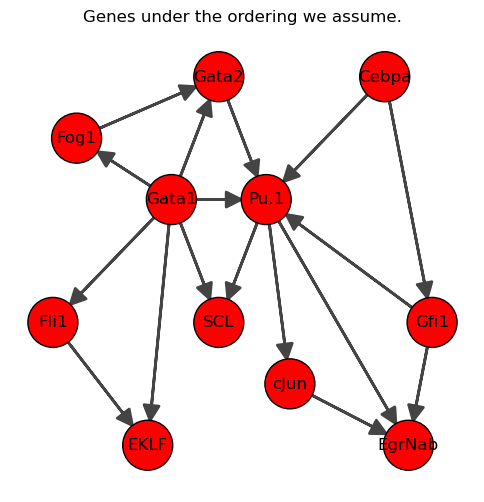

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

random.seed(1)
gene_graph = ig.Graph.Weighted_Adjacency(ordered_truth.T)
gene_graph.vs["label"] = ordered_truth.coords["to"].data

ig.plot(
    gene_graph,
    target=ax,
    vertex_size=50,
    layout=gene_layout
)

ax.set_title("Genes under the ordering we assume.")
pass

## Running the Cartesian-LGAM on this dataset

The CLGAM model for matrix-variate data in theory has 4 hyperparameters - an L1 and L2 value for each axis.  However, we've been keeping the L2 norms identical for both axes; thus, there are 3.  Let's first investigate the effect of the two L1 parameters.

For graph-producing algorithms, it's hard to have an empirical metric - how does one define what a 'good' graph is?  For cells, we'd like to capture the pseudo-temporal structure, but it's hard to put a precise metric on that.  A good metric for the gene graph would be Matthew's Correlation Coefficient (MCC), so we'll use that for the grid search.  Interestingly, we'll see that by optimizing for a good result on the gene graph, we'll end up with good results on the cell graph as well!

### L1 Parameters

Grid searching takes a few hours - it's mostly held up by the grid squares with little regularization, as dense graphs take the longest to learn.  We only include those here for completeness (so that we cover 100% sparse and 100% dense cases), but if you want to speed it up, cut those out.

In [13]:
dataset = ordered_krum.X.copy()

# Empirically, normalizing to CPM speeds up computation by a factor of 10,
# which is a lifesaver when running over a big grid!!
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))

cell_range = np.logspace(-0.5, -4.5, 10)
gene_range = np.logspace(1, -2, 10)

glassoregs = [
    (y, x)
    for x in gene_range
    for y in cell_range
]

Lss, diagnostics = warm_start(
    dataset,
    L_init=L_init,
    glassoregs = glassoregs,
    frobreg=frobreg,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    verbose=True,
    dont_warm_start=True # numerical stability is causing problems...
)

L1 Param: (np.float64(0.31622776601683794), np.float64(10.0))


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: (np.float64(0.11364636663857249), np.float64(10.0))
L1 Param: (np.float64(0.04084238652674522), np.float64(10.0))
L1 Param: (np.float64(0.014677992676220698), np.float64(10.0))
L1 Param: (np.float64(0.00527499706370262), np.float64(10.0))
L1 Param: (np.float64(0.0018957356524063754), np.float64(10.0))
L1 Param: (np.float64(0.0006812920690579615), np.float64(10.0))
L1 Param: (np.float64(0.0002448436746822229), np.float64(10.0))
L1 Param: (np.float64(8.799225435691074e-05), np.float64(10.0))
L1 Param: (np.float64(3.1622776601683795e-05), np.float64(10.0))
L1 Param: (np.float64(0.31622776601683794), np.float64(4.641588833612779))
L1 Param: (np.float64(0.11364636663857249), np.float64(4.641588833612779))
L1 Param: (np.float64(0.04084238652674522), np.float64(4.641588833612779))
L1 Param: (np.float64(0.014677992676220698), np.float64(4.641588833612779))
L1 Param: (np.float64(0.00527499706370262), np.float64(4.641588833612779))
L1 Param: (np.float64(0.0018957356524063754), np.float

It takes 300 MB to save the results, but I highly recommend it since it takes so long to generate them...

In [14]:
# Save to pickle file
with open("results/krum_grid", "wb") as fp:
    pickle.dump(Lss, fp)

In [17]:
with open("results/krum_grid", "rb") as fp:
    Lss = pickle.load(fp)

len(Lss)

100

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_90559/1763472556.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cells.vs["cell_type"] = ordered_krum.obs["cell_type"].cat.codes
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_90559/1763472556.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cells.vs["cell_type"] = ordered_krum.obs["cell_type"].cat.codes
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_90559/1763472556.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

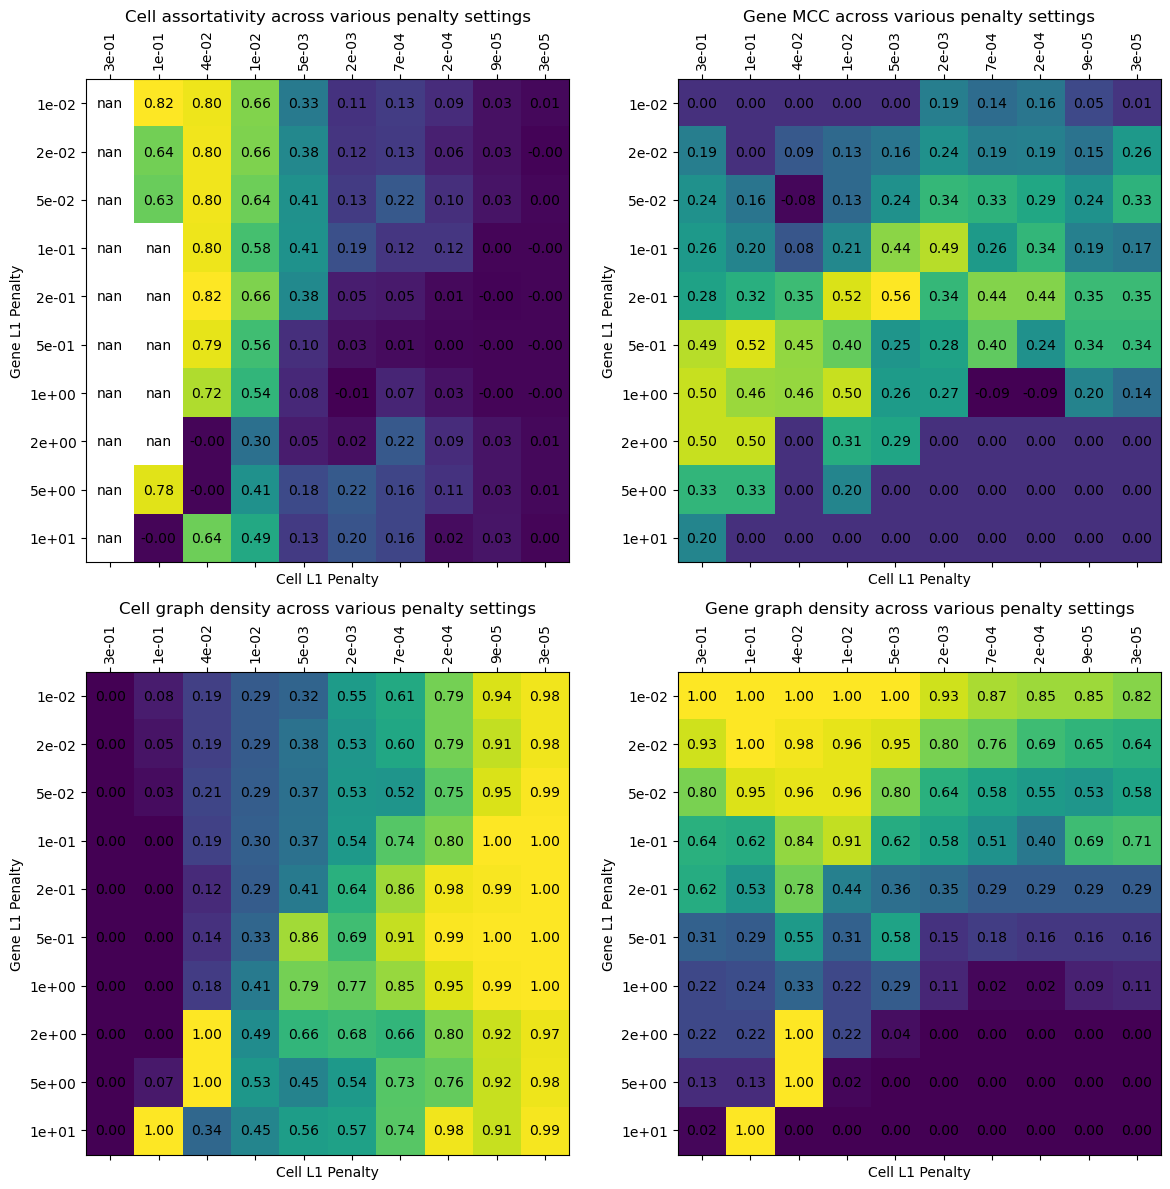

In [ ]:
assorts = []
mccs = []
f1s = []
precs = []
recs = []
cell_sparsities = []
gene_sparsities = []
for Ls in Lss:
    # Get cell assortativity
    cells = ig.Graph.Weighted_Adjacency(Ls[0]).simplify()
    cells.vs["cell_type"] = ordered_krum.obs["cell_type"].cat.codes
    assorts.append(cells.assortativity(cells.vs["cell_type"]))

    # Get gene mcc
    flat_genes = Ls[1][np.tril_indices(11, k=-1)] != 0
    flat_graph = ordered_truth.data[np.tril_indices(11, k=-1)] != 0
    
    mccs.append(matthews_corrcoef(flat_graph, flat_genes))
    f1s.append(f1_score(flat_graph, flat_genes))
    precs.append(precision_score(flat_graph, flat_genes))
    recs.append(recall_score(flat_graph, flat_genes))

    # Sparsities
    cell_sparsities.append(2 * (np.tril(Ls[0], k=-1) != 0).sum() / (Ls[0].shape[0]**2 - Ls[0].shape[0]))
    gene_sparsities.append(2 * (np.tril(Ls[1], k=-1) != 0).sum() / (Ls[1].shape[0]**2 - Ls[1].shape[0]))
    

mccs = np.array(mccs).reshape(len(gene_range), len(cell_range))
assorts = np.array(assorts).reshape(len(gene_range), len(cell_range))
precs = np.array(precs).reshape(len(gene_range), len(cell_range))
recs = np.array(recs).reshape(len(gene_range), len(cell_range))
f1s = np.array(f1s).reshape(len(gene_range), len(cell_range))
cell_sparsities = np.array(cell_sparsities).reshape(len(gene_range), len(cell_range))
gene_sparsities = np.array(gene_sparsities).reshape(len(gene_range), len(cell_range))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12, 12), ncols=2, nrows=2)
ax1.matshow(assorts)
ax1.set_xticks(np.arange(11)-1)
ax1.set_yticks(np.arange(11)-1)
ax1.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax1.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax1.set_xlabel("Cell L1 Penalty")
ax1.set_ylabel("Gene L1 Penalty")
ax1.set_title("Cell assortativity across various penalty settings")

for i in range(assorts.shape[0]): # rows
    for j in range(assorts.shape[1]): # columns
        text = ax1.text(j, i, f"{assorts[i, j]:.2f}",
                       ha="center", va="center", color="black")

ax2.matshow(mccs)
ax2.set_xticks(np.arange(11)-1)
ax2.set_yticks(np.arange(11)-1)
ax2.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax2.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax2.set_xlabel("Cell L1 Penalty")
ax2.set_ylabel("Gene L1 Penalty")
ax2.set_title("Gene MCC across various penalty settings")

for i in range(mccs.shape[0]): # rows
    for j in range(mccs.shape[1]): # columns
        text = ax2.text(j, i, f"{mccs[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
ax3.matshow(cell_sparsities)
ax3.set_xticks(np.arange(11)-1)
ax3.set_yticks(np.arange(11)-1)
ax3.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax3.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax3.set_xlabel("Cell L1 Penalty")
ax3.set_ylabel("Gene L1 Penalty")
ax3.set_title("Cell graph density across various penalty settings")

for i in range(cell_sparsities.shape[0]): # rows
    for j in range(cell_sparsities.shape[1]): # columns
        text = ax3.text(j, i, f"{cell_sparsities[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
ax4.matshow(gene_sparsities)
ax4.set_xticks(np.arange(11)-1)
ax4.set_yticks(np.arange(11)-1)
ax4.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax4.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax4.set_xlabel("Cell L1 Penalty")
ax4.set_ylabel("Gene L1 Penalty")
ax4.set_title("Gene graph density across various penalty settings")

for i in range(gene_sparsities.shape[0]): # rows
    for j in range(gene_sparsities.shape[1]): # columns
        text = ax4.text(j, i, f"{gene_sparsities[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
for ax in (ax1, ax2, ax3, ax4):
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlim(-0.5, 9.5)
    ax.set_ylim(-0.5, 9.5)

fig.tight_layout()
        
pass

Let's look at the top three results.

In [52]:
sorting = mccs.reshape(-1).argsort()[::-1]
print(mccs.reshape(-1)[sorting][:5])
print(sorting[:5])

[0.5576555  0.52448815 0.5221627  0.50402477 0.50402477]
[54 41 53 20 21]


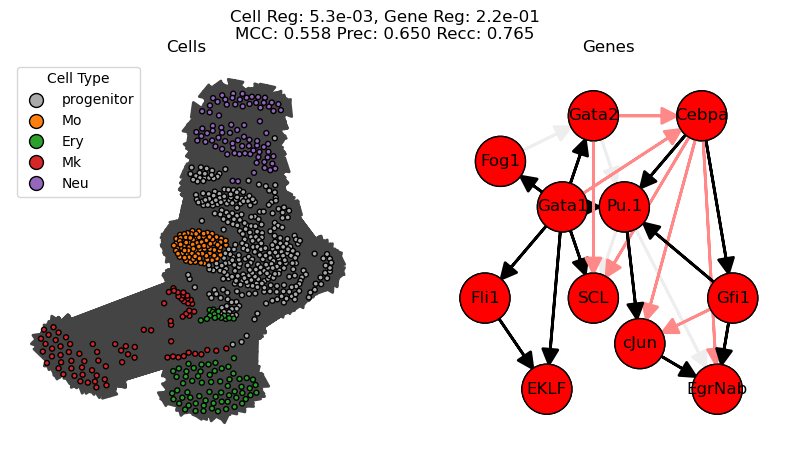

In [107]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
glassoreg = glassoregs[sorting[0]]

# Must transpose - convention in iGraph is that i -> j, whereas with LGAM It's j -> i
cell_graph = ig.Graph.Weighted_Adjacency(Lss[sorting[0]][0].T - np.diag(np.diag(Lss[sorting[0]][0])))
cell_types = ordered_krum.obs['cell_type']
type_to_color = {ctype: ordered_krum.uns['cell_type_colors'][i % len(ordered_krum.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
#cell_graph.vs["edge_color"] = cell_graph.vs["color"]
#cell_graph.es["color"] = ['red' if w > 0 else 'blue' for w in cell_graph.es["weight"]]

random.seed(0)
cell_layout = cell_graph.layout(layout='auto')

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5,
    layout=cell_layout
)

# First, plot the 'true gene graph' to show false negatives
true_gene_graph = ig.Graph.Weighted_Adjacency(np.tril(ordered_truth, k=-1).T)
true_gene_graph.es["color"] = ['#eeeeee' for edge in true_gene_graph.es]
ig.plot(
    true_gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout,
)

gene_graph = ig.Graph.Weighted_Adjacency(Lss[sorting[0]][1].T - np.diag(np.diag(Lss[sorting[0]][1])))
gene_graph.vs["label"] = ordered_krum.var_names
#gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]
gene_graph.es["color"] = ['black' if ordered_truth.data[edge.target, edge.source] else '#ff8888' for edge in gene_graph.es]

ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Cells")
ax2.set_title("Genes")

# Add legend
# Extract colors and labels
colors = ordered_krum.uns['cell_type_colors']
labels = ordered_krum.obs['cell_type'].unique()

# Build legend handles
handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=color, markersize=10, label=label)
    for label, color in zip(labels, colors)
]
ax1.legend(handles=handles, title='Cell Type', loc='upper left')
fig.suptitle(
    f"Cell Reg: {glassoreg[0]:.1e}, Gene Reg: {glassoreg[1]:.1e}"
    + f"\nMCC: {mccs.reshape(-1)[sorting[0]]:.3f}"
    + f" Prec: {precs.reshape(-1)[sorting[0]]:.3f}"
    + f" Recc: {recs.reshape(-1)[sorting[0]]:.3f}"
)
pass

The cell graph seems well-clustered, but it doesn't seem to be capturing the pseudotemporal nature of the data.

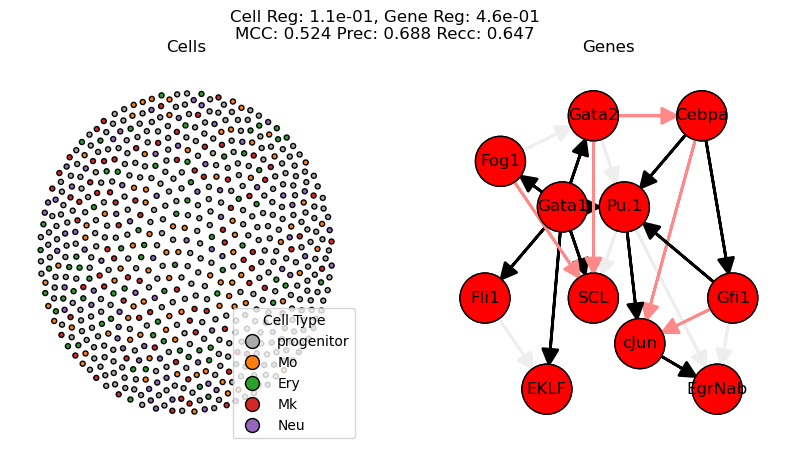

In [106]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
glassoreg = glassoregs[sorting[1]]

# Must transpose - convention in iGraph is that i -> j, whereas with LGAM It's j -> i
cell_graph = ig.Graph.Weighted_Adjacency(Lss[sorting[1]][0].T - np.diag(np.diag(Lss[sorting[1]][0])))
cell_types = ordered_krum.obs['cell_type']
type_to_color = {ctype: ordered_krum.uns['cell_type_colors'][i % len(ordered_krum.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
#cell_graph.vs["edge_color"] = cell_graph.vs["color"]
#cell_graph.es["color"] = ['red' if w > 0 else 'blue' for w in cell_graph.es["weight"]]

random.seed(0)
cell_layout = cell_graph.layout(layout='auto')

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5,
    layout=cell_layout
)

# First, plot the 'true gene graph' to show false negatives
true_gene_graph = ig.Graph.Weighted_Adjacency(np.tril(ordered_truth, k=-1).T)
true_gene_graph.es["color"] = ['#eeeeee' for edge in true_gene_graph.es]
ig.plot(
    true_gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout,
)

gene_graph = ig.Graph.Weighted_Adjacency(Lss[sorting[1]][1].T - np.diag(np.diag(Lss[sorting[1]][1])))
gene_graph.vs["label"] = ordered_krum.var_names
#gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]
gene_graph.es["color"] = ['black' if ordered_truth.data[edge.target, edge.source] else '#ff8888' for edge in gene_graph.es]

ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Cells")
ax2.set_title("Genes")

# Add legend
# Extract colors and labels
colors = ordered_krum.uns['cell_type_colors']
labels = ordered_krum.obs['cell_type'].unique()

# Build legend handles
handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=color, markersize=10, label=label)
    for label, color in zip(labels, colors)
]
ax1.legend(handles=handles, title='Cell Type', loc='lower right')
fig.suptitle(
    f"Cell Reg: {glassoreg[0]:.1e}, Gene Reg: {glassoreg[1]:.1e}"
    + f"\nMCC: {mccs.reshape(-1)[sorting[1]]:.3f}"
    + f" Prec: {precs.reshape(-1)[sorting[1]]:.3f}"
    + f" Recc: {recs.reshape(-1)[sorting[1]]:.3f}"
)
pass

This corresponds with the graph we get under the assumption of independence of cells - not bad!

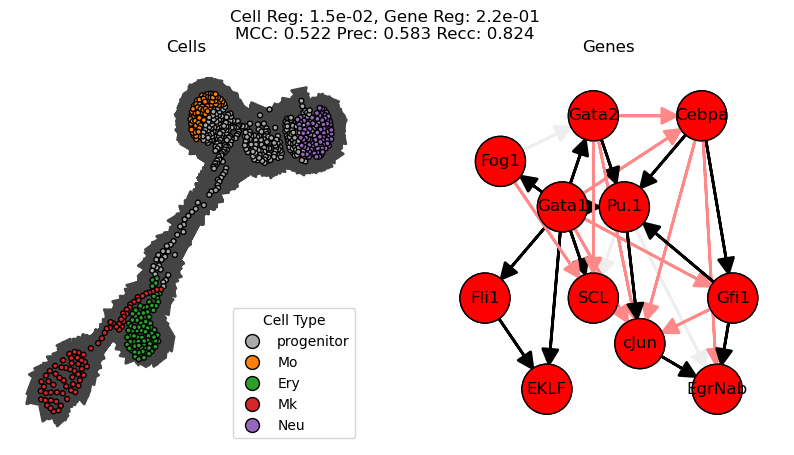

In [98]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
glassoreg = glassoregs[sorting[2]]

# Must transpose - convention in iGraph is that i -> j, whereas with LGAM It's j -> i
cell_graph = ig.Graph.Weighted_Adjacency(Lss[sorting[2]][0].T - np.diag(np.diag(Lss[sorting[2]][0])))
cell_types = ordered_krum.obs['cell_type']
type_to_color = {ctype: ordered_krum.uns['cell_type_colors'][i % len(ordered_krum.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
#cell_graph.vs["edge_color"] = cell_graph.vs["color"]
#cell_graph.es["color"] = ['red' if w > 0 else 'blue' for w in cell_graph.es["weight"]]

random.seed(0)
cell_layout = cell_graph.layout(layout='auto')

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5,
    layout=cell_layout
)

# First, plot the 'true gene graph' to show false negatives
true_gene_graph = ig.Graph.Weighted_Adjacency(np.tril(ordered_truth, k=-1).T)
true_gene_graph.es["color"] = ['#eeeeee' for edge in true_gene_graph.es]
ig.plot(
    true_gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout,
)

gene_graph = ig.Graph.Weighted_Adjacency(Lss[sorting[2]][1].T - np.diag(np.diag(Lss[sorting[2]][1])))
gene_graph.vs["label"] = ordered_krum.var_names
#gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]
gene_graph.es["color"] = ['black' if ordered_truth.data[edge.target, edge.source] else '#ff8888' for edge in gene_graph.es]

ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Cells")
ax2.set_title("Genes")

# Add legend
# Extract colors and labels
colors = ordered_krum.uns['cell_type_colors']
labels = ordered_krum.obs['cell_type'].unique()

# Build legend handles
handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=color, markersize=10, label=label)
    for label, color in zip(labels, colors)
]
ax1.legend(handles=handles, title='Cell Type', loc='lower right')
fig.suptitle(
    f"Cell Reg: {glassoreg[0]:.1e}, Gene Reg: {glassoreg[1]:.1e}"
    + f"\nMCC: {mccs.reshape(-1)[sorting[2]]:.3f}"
    + f" Prec: {precs.reshape(-1)[sorting[2]]:.3f}"
    + f" Recc: {recs.reshape(-1)[sorting[2]]:.3f}"
)
pass

Here we can clearly see the pseudotemporal structure - great!

## Frobenius penalty investigation

Now, we will play with the L2 parameter.  While the primary use of this parameter is to ensure the existence of a minimizer, it also has an effect on solution quality.

In [108]:
frob_mccs = []
frobregs = np.logspace(-2, 2, 100) / np.prod(dims)**(1/len(dims))
for frobreg in frobregs:
    dataset = ordered_krum.X.copy()
    dataset /= dataset.sum(axis=1).reshape(-1, 1)
    dims = dataset.shape
    L_init = [np.eye(d) for d in dims]

    glassoreg = glassoregs[sorting[2]]
    objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

    Ls_out, (_, eps, _, _) = proximal_accelerated_gradient(
        f=objective,
        del_f=gradient,
        prox=proximal,
        P=project_to_lower_with_positive_diag,
        Ls=L_init,
        mu=0.2,
        init_alpha=1,
        tau=0.5,
        beta=0.0001,
        max_iter=1000,
        tol=1e-10,
        _delay_proximal_until=1
    )

    flat_genes = Ls_out[1][np.tril_indices(11, k=-1)] != 0
    flat_graph = ordered_truth.data[np.tril_indices(11, k=-1)] != 0
    mcc_ = matthews_corrcoef(flat_graph, flat_genes)
    frob_mccs.append(mcc_)
    print(f"Reg: {frobreg:.2e}\t MCC: {mcc_:.4f}")

/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.19e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.31e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.44e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.58e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.73e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.90e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.08e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.29e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.51e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.75e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.02e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.32e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.64e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.99e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 4.38e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 4.81e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 5.28e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 5.80e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 6.36e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 6.98e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 7.66e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 8.41e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 9.23e-04	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.01e-03	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.11e-03	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.22e-03	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.34e-03	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.47e-03	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.61e-03	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.77e-03	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.94e-03	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.13e-03	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.34e-03	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.57e-03	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.82e-03	 MCC: 0.4994


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.09e-03	 MCC: 0.4994


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.39e-03	 MCC: 0.4994


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.73e-03	 MCC: 0.4994


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 4.09e-03	 MCC: 0.4994


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 4.49e-03	 MCC: 0.4994


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 4.92e-03	 MCC: 0.4994


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 5.40e-03	 MCC: 0.4994


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 5.93e-03	 MCC: 0.4994


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 6.51e-03	 MCC: 0.4994


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 7.14e-03	 MCC: 0.4994


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 7.84e-03	 MCC: 0.5545


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 8.61e-03	 MCC: 0.5222


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 9.45e-03	 MCC: 0.5222


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.04e-02	 MCC: 0.5222


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.14e-02	 MCC: 0.5222


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.25e-02	 MCC: 0.5488


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.37e-02	 MCC: 0.5488


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.50e-02	 MCC: 0.5488


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.65e-02	 MCC: 0.5488


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.81e-02	 MCC: 0.5488


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.99e-02	 MCC: 0.5488


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.18e-02	 MCC: 0.5488


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.39e-02	 MCC: 0.5488


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.63e-02	 MCC: 0.5222


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.88e-02	 MCC: 0.4956


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.17e-02	 MCC: 0.4956


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.47e-02	 MCC: 0.3912


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.81e-02	 MCC: 0.5222


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 4.18e-02	 MCC: 0.4699


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 4.59e-02	 MCC: 0.5222


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 5.04e-02	 MCC: 0.5222


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 5.53e-02	 MCC: 0.4979


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 6.07e-02	 MCC: 0.4956


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 6.66e-02	 MCC: 0.4450


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 7.31e-02	 MCC: 0.4994


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 8.03e-02	 MCC: 0.4994


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 8.81e-02	 MCC: 0.4096


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 9.67e-02	 MCC: 0.4096


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.06e-01	 MCC: 0.4096


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.16e-01	 MCC: 0.4284


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.28e-01	 MCC: 0.4284


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.40e-01	 MCC: 0.4284


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.54e-01	 MCC: 0.4284


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.69e-01	 MCC: 0.4284


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.85e-01	 MCC: 0.4284


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.03e-01	 MCC: 0.4298


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.23e-01	 MCC: 0.4298


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.45e-01	 MCC: 0.4298


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.69e-01	 MCC: 0.4298


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.95e-01	 MCC: 0.4298


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.24e-01	 MCC: 0.4757


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.56e-01	 MCC: 0.4207


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.90e-01	 MCC: 0.4207


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 4.28e-01	 MCC: 0.4450


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 4.70e-01	 MCC: 0.4450


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 5.16e-01	 MCC: 0.4450


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 5.66e-01	 MCC: 0.4166


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 6.21e-01	 MCC: 0.4075


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 6.82e-01	 MCC: 0.4075


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 7.49e-01	 MCC: 0.4075


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 8.21e-01	 MCC: 0.4075


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 9.02e-01	 MCC: 0.4075


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 9.89e-01	 MCC: 0.4298


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.09e+00	 MCC: 0.4298


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.19e+00	 MCC: 0.4207


In [110]:
# Save to pickle file
with open("results/krum_mccs", "wb") as fp:
    pickle.dump((frobregs, frob_mccs), fp)

In [ ]:
with open("results/krum_mccs", "rb") as fp:
    _frobregs, _frob_mccs = pickle.load(fp)
print(_frobregs[0:5]) # FINAL CHECK - are these the same?  If so, saving worked :)
print(frobregs[0:5])

Text(0.5, 1.0, 'Gene graph MCC as we vary the Frobenius penalty')

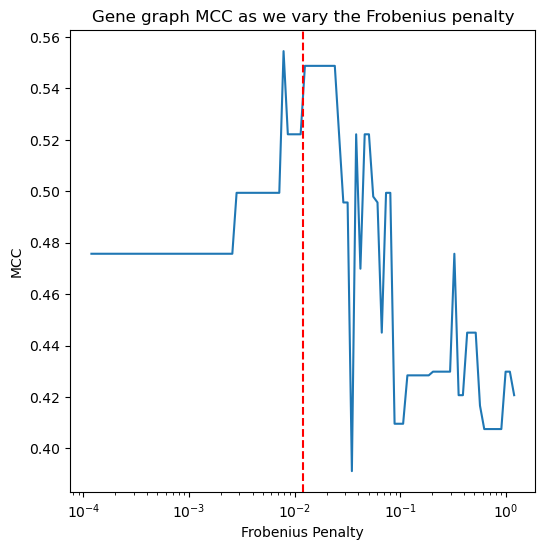

In [109]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(frobregs, frob_mccs)
ax.axvline(1 / np.prod(dims)**(1/len(dims)), linestyle='--', color='red')
ax.set_xlabel("Frobenius Penalty")
ax.set_xscale("log")
ax.set_ylabel("MCC")
ax.set_title("Gene graph MCC as we vary the Frobenius penalty")

Now, we'll see how much of an effect this parameter has on solutions, by viewing the result with the best Frobenius penalty.

In [115]:
best_frobreg = frobregs[np.array(frob_mccs).argmax()]

dataset = ordered_krum.X.copy()
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

glassoreg = glassoregs[sorting[2]]
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=best_frobreg, glassoregs=glassoreg)

Ls_best_frobreg, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    _delay_proximal_until=1
)

/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


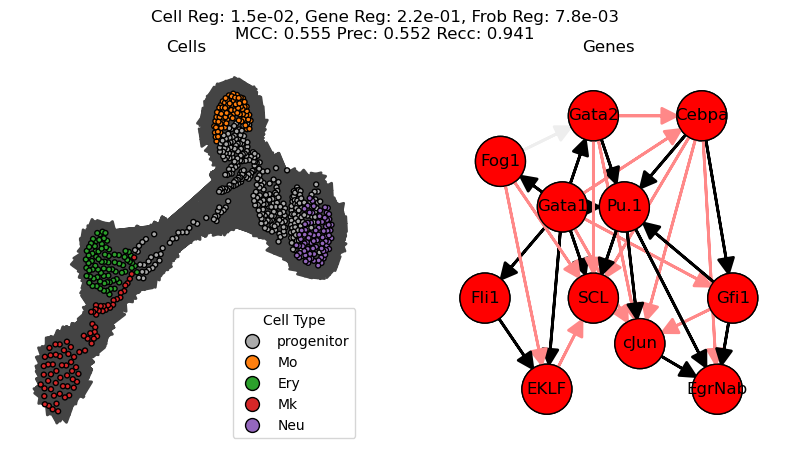

In [132]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
glassoreg = glassoregs[sorting[2]]
best_frobreg = frobregs[np.array(frob_mccs).argmax()]

# Must transpose - convention in iGraph is that i -> j, whereas with LGAM It's j -> i
cell_graph = ig.Graph.Weighted_Adjacency(Ls_best_frobreg[0].T - np.diag(np.diag(Ls_best_frobreg[0])))
cell_types = ordered_krum.obs['cell_type']
type_to_color = {ctype: ordered_krum.uns['cell_type_colors'][i % len(ordered_krum.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
#cell_graph.vs["edge_color"] = cell_graph.vs["color"]
#cell_graph.es["color"] = ['red' if w > 0 else 'blue' for w in cell_graph.es["weight"]]

random.seed(0)
cell_layout = cell_graph.layout(layout='auto')

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5,
    layout=cell_layout
)

# First, plot the 'true gene graph' to show false negatives
true_gene_graph = ig.Graph.Weighted_Adjacency(np.tril(ordered_truth, k=-1).T)
true_gene_graph.es["color"] = ['#eeeeee' for edge in true_gene_graph.es]
ig.plot(
    true_gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout,
)

gene_graph = ig.Graph.Weighted_Adjacency(Ls_best_frobreg[1].T - np.diag(np.diag(Ls_best_frobreg[1])))
gene_graph.vs["label"] = ordered_krum.var_names
#gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]
gene_graph.es["color"] = ['black' if ordered_truth.data[edge.target, edge.source] else '#ff8888' for edge in gene_graph.es]

ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Cells")
ax2.set_title("Genes")

# Add legend
# Extract colors and labels
colors = ordered_krum.uns['cell_type_colors']
labels = ordered_krum.obs['cell_type'].unique()

# Build legend handles
handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=color, markersize=10, label=label)
    for label, color in zip(labels, colors)
]
ax1.legend(handles=handles, title='Cell Type', loc='lower right')

flat_genes = Ls_best_frobreg[1][np.tril_indices(11, k=-1)] != 0
flat_graph = ordered_truth.data[np.tril_indices(11, k=-1)] != 0
mcc_ = matthews_corrcoef(flat_graph, flat_genes)
prec_ = precision_score(flat_graph, flat_genes)
rec_ = recall_score(flat_graph, flat_genes)

fig.suptitle(
    f"Cell Reg: {glassoreg[0]:.1e}, Gene Reg: {glassoreg[1]:.1e}, Frob Reg: {best_frobreg:.1e}"
    + f"\nMCC: {mcc_:.3f}"
    + f" Prec: {prec_:.3f}"
    + f" Recc: {rec_:.3f}"
)
pass

Finding the best Frobenius penalty has not really affected the cell graph much, but it has altered the gene graph to recall more edges, sacrificing some precision to achieve a higher recall.

What about the graph with the best MCC?

In [ ]:
frob_mccs_best = []
frobregs = np.logspace(-2, 2, 100) / np.prod(dims)**(1/len(dims))
for frobreg in frobregs:
    dataset = ordered_krum.X.copy()
    dataset /= dataset.sum(axis=1).reshape(-1, 1)
    dims = dataset.shape
    L_init = [np.eye(d) for d in dims]

    glassoreg = glassoregs[sorting[0]]
    objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

    Ls_out, (_, eps, _, _) = proximal_accelerated_gradient(
        f=objective,
        del_f=gradient,
        prox=proximal,
        P=project_to_lower_with_positive_diag,
        Ls=L_init,
        mu=0.2,
        init_alpha=1,
        tau=0.5,
        beta=0.0001,
        max_iter=1000,
        tol=1e-10,
        _delay_proximal_until=1
    )

    flat_genes = Ls_out[1][np.tril_indices(11, k=-1)] != 0
    flat_graph = ordered_truth.data[np.tril_indices(11, k=-1)] != 0
    mcc_ = matthews_corrcoef(flat_graph, flat_genes)
    frob_mccs_best.append(mcc_)
    print(f"Reg: {frobreg:.2e}\t MCC: {mcc_:.4f}")

/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.19e-04	 MCC: 0.3855


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.31e-04	 MCC: 0.3855


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.44e-04	 MCC: 0.3855


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.58e-04	 MCC: 0.3855


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.73e-04	 MCC: 0.3855


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.90e-04	 MCC: 0.3855


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.08e-04	 MCC: 0.3855


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.29e-04	 MCC: 0.3855


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.51e-04	 MCC: 0.3855


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.75e-04	 MCC: 0.3855


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.02e-04	 MCC: 0.3855


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.32e-04	 MCC: 0.3855


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.64e-04	 MCC: 0.6394


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.99e-04	 MCC: 0.5897


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 4.38e-04	 MCC: 0.5271


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 4.81e-04	 MCC: 0.6394


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 5.28e-04	 MCC: 0.6235


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 5.80e-04	 MCC: 0.5577


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 6.36e-04	 MCC: 0.5577


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 6.98e-04	 MCC: 0.5577


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 7.66e-04	 MCC: 0.6235


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 8.41e-04	 MCC: 0.6394


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 9.23e-04	 MCC: 0.6394


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.01e-03	 MCC: 0.5897


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.11e-03	 MCC: 0.5782


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.22e-03	 MCC: 0.5897


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.34e-03	 MCC: 0.6235


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.47e-03	 MCC: 0.5577


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.61e-03	 MCC: 0.5577


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.77e-03	 MCC: 0.5897


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 1.94e-03	 MCC: 0.5897


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.13e-03	 MCC: 0.6235


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.34e-03	 MCC: 0.5271


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.57e-03	 MCC: 0.5271


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 2.82e-03	 MCC: 0.5577


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.09e-03	 MCC: 0.6394


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.39e-03	 MCC: 0.6586


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


Reg: 3.73e-03	 MCC: 0.6235


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


In [ ]:
# Save to pickle file
with open("results/krum_mccs_best", "wb") as fp:
    pickle.dump((frobregs, frob_mccs_best), fp)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(frobregs, frob_mccs_best)
ax.axvline(1 / np.prod(dims)**(1/len(dims)), linestyle='--', color='red')
ax.set_xlabel("Frobenius Penalty")
ax.set_xscale("log")
ax.set_ylabel("MCC")
ax.set_title("Gene graph MCC as we vary the Frobenius penalty")

In [ ]:
best_frobreg = frobregs[np.array(frob_mccs_best).argmax()]

dataset = ordered_krum.X.copy()
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

glassoreg = glassoregs[sorting[0]]
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=best_frobreg, glassoregs=glassoreg)

Ls_best_frobreg_best, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    _delay_proximal_until=1
)

In [ ]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
glassoreg = glassoregs[sorting[0]]
best_frobreg = frobregs[np.array(frob_mccs_best).argmax()]

# Must transpose - convention in iGraph is that i -> j, whereas with LGAM It's j -> i
cell_graph = ig.Graph.Weighted_Adjacency(Ls_best_frobreg_best[0].T - np.diag(np.diag(Ls_best_frobreg_best[0])))
cell_types = ordered_krum.obs['cell_type']
type_to_color = {ctype: ordered_krum.uns['cell_type_colors'][i % len(ordered_krum.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
#cell_graph.vs["edge_color"] = cell_graph.vs["color"]
#cell_graph.es["color"] = ['red' if w > 0 else 'blue' for w in cell_graph.es["weight"]]

random.seed(0)
cell_layout = cell_graph.layout(layout='auto')

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5,
    layout=cell_layout
)

# First, plot the 'true gene graph' to show false negatives
true_gene_graph = ig.Graph.Weighted_Adjacency(np.tril(ordered_truth, k=-1).T)
true_gene_graph.es["color"] = ['#eeeeee' for edge in true_gene_graph.es]
ig.plot(
    true_gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout,
)

gene_graph = ig.Graph.Weighted_Adjacency(Ls_best_frobreg_best[1].T - np.diag(np.diag(Ls_best_frobreg_best[1])))
gene_graph.vs["label"] = ordered_krum.var_names
#gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]
gene_graph.es["color"] = ['black' if ordered_truth.data[edge.target, edge.source] else '#ff8888' for edge in gene_graph.es]

ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Cells")
ax2.set_title("Genes")

# Add legend
# Extract colors and labels
colors = ordered_krum.uns['cell_type_colors']
labels = ordered_krum.obs['cell_type'].unique()

# Build legend handles
handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=color, markersize=10, label=label)
    for label, color in zip(labels, colors)
]
ax1.legend(handles=handles, title='Cell Type', loc='lower right')

flat_genes = Ls_best_frobreg_best[1][np.tril_indices(11, k=-1)] != 0
flat_graph = ordered_truth.data[np.tril_indices(11, k=-1)] != 0
mcc_ = matthews_corrcoef(flat_graph, flat_genes)
prec_ = precision_score(flat_graph, flat_genes)
rec_ = recall_score(flat_graph, flat_genes)

fig.suptitle(
    f"Cell Reg: {glassoreg[0]:.1e}, Gene Reg: {glassoreg[1]:.1e}, Frob Reg: {best_frobreg:.1e}"
    + f"\nMCC: {mcc_:.3f}"
    + f" Prec: {prec_:.3f}"
    + f" Recc: {rec_:.3f}"
)
pass

## Cell graph performance

Analyzing cell graph performance is harder - we could use assortativity to measure the tendency of cells of the same cell type to connect to each other, but it's easy for sparse graphs to have high assortativity by pure chance.  A more robust measure would be the ability for cells of the same cell type to cluster together.  However, clustering comes with its own problems: which algorithm do we use, what hyperparameters do we use, and what metrics do we use?

We'll use Leiden, as it is a standard clustering algorithm in the ScanPy scRNA-seq workflow.  Then, we'll report a variety of metrics across a variety of Leiden's hyperparameters.  We'll use the 3rd best MCC gene graph, as its cell graph was the most compelling.

In [136]:
ordered_krum.obsp["clgam"] = 1.0 * (Lss[sorting[2]][0] != 0)
ordered_krum

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type'
    var: 'variance'
    uns: 'iroot', 'highlights', 'cell_type_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'clgam'

In [142]:
resolutions = [0.6, 0.7, 0.8, 0.9, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5]
num_res = len(resolutions)
results = np.zeros((num_res, 4))

for i, resolution in enumerate(resolutions):
    sc.tl.leiden(ordered_krum, obsp="clgam", key_added=f"clgam_leiden_{resolution}", resolution=resolution)
    results[i, 0] = homogeneity_score(ordered_krum.obs['cell_type'], ordered_krum.obs[f"clgam_leiden_{resolution}"])
    results[i, 1] = completeness_score(ordered_krum.obs['cell_type'], ordered_krum.obs[f"clgam_leiden_{resolution}"])
    results[i, 2] = adjusted_mutual_info_score(ordered_krum.obs['cell_type'], ordered_krum.obs[f"clgam_leiden_{resolution}"])
    results[i, 3] = adjusted_rand_score(ordered_krum.obs['cell_type'], ordered_krum.obs[f"clgam_leiden_{resolution}"])

(0.0, 1.0)

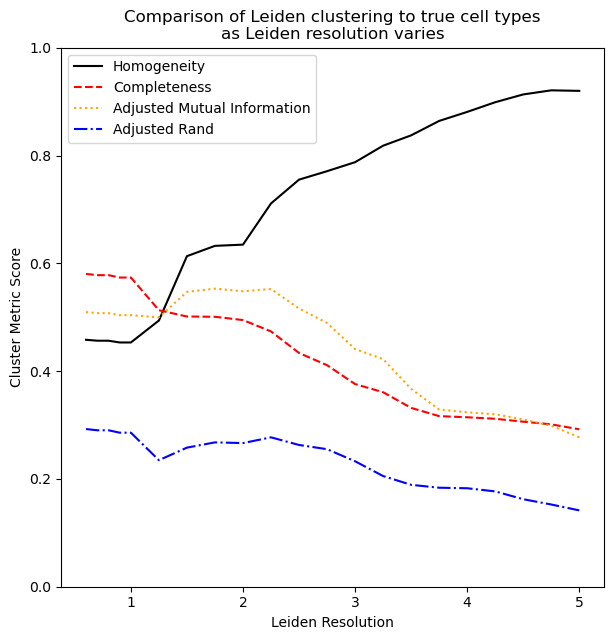

In [143]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(resolutions, results[:, 0], color='black', linestyle='-', label="Homogeneity")
ax.plot(resolutions, results[:, 1], color='red', linestyle='--', label="Completeness")
ax.plot(resolutions, results[:, 2], color='orange', linestyle=':', label="Adjusted Mutual Information")
ax.plot(resolutions, results[:, 3], color='blue', linestyle='-.', label="Adjusted Rand")

ax.legend(loc="upper left")
ax.set_xlabel("Leiden Resolution")
ax.set_ylabel("Cluster Metric Score")
ax.set_title("Comparison of Leiden clustering to true cell types\nas Leiden resolution varies")
ax.set_ylim([0, 1])

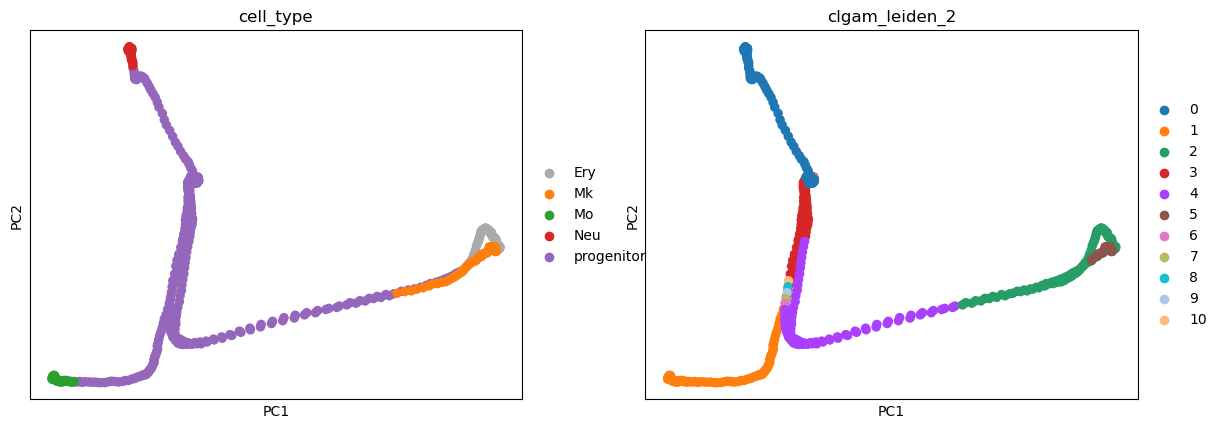

In [150]:
sc.pl.pca(ordered_krum, color=["cell_type", "clgam_leiden_2"])

What about the `sorting[0]`?

In [151]:
ordered_krum.obsp["best_clgam"] = 1.0 * (Lss[sorting[0]][0] != 0)
ordered_krum

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'clgam_leiden', 'clgam_leiden_0.6', 'clgam_leiden_0.7', 'clgam_leiden_0.8', 'clgam_leiden_0.9', 'clgam_leiden_1', 'clgam_leiden_1.25', 'clgam_leiden_1.5', 'clgam_leiden_1.75', 'clgam_leiden_2', 'clgam_leiden_2.25', 'clgam_leiden_2.5', 'clgam_leiden_2.75', 'clgam_leiden_3', 'clgam_leiden_3.25', 'clgam_leiden_3.5', 'clgam_leiden_3.75', 'clgam_leiden_4', 'clgam_leiden_4.25', 'clgam_leiden_4.5', 'clgam_leiden_4.75', 'clgam_leiden_5'
    var: 'variance'
    uns: 'iroot', 'highlights', 'cell_type_colors', 'pca', 'clgam_leiden', 'clgam_leiden_0.6', 'clgam_leiden_0.7', 'clgam_leiden_0.8', 'clgam_leiden_0.9', 'clgam_leiden_1', 'clgam_leiden_1.25', 'clgam_leiden_1.5', 'clgam_leiden_1.75', 'clgam_leiden_2', 'clgam_leiden_2.25', 'clgam_leiden_2.5', 'clgam_leiden_2.75', 'clgam_leiden_3', 'clgam_leiden_3.25', 'clgam_leiden_3.5', 'clgam_leiden_3.75', 'clgam_leiden_4', 'clgam_leiden_4.25', 'clgam_leiden_4.5', 'clgam_leiden_4.75', 'clg

In [152]:
resolutions = [0.6, 0.7, 0.8, 0.9, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5]
num_res = len(resolutions)
results = np.zeros((num_res, 4))

for i, resolution in enumerate(resolutions):
    sc.tl.leiden(ordered_krum, obsp="best_clgam", key_added=f"best_clgam_leiden_{resolution}", resolution=resolution)
    results[i, 0] = homogeneity_score(ordered_krum.obs['cell_type'], ordered_krum.obs[f"best_clgam_leiden_{resolution}"])
    results[i, 1] = completeness_score(ordered_krum.obs['cell_type'], ordered_krum.obs[f"best_clgam_leiden_{resolution}"])
    results[i, 2] = adjusted_mutual_info_score(ordered_krum.obs['cell_type'], ordered_krum.obs[f"best_clgam_leiden_{resolution}"])
    results[i, 3] = adjusted_rand_score(ordered_krum.obs['cell_type'], ordered_krum.obs[f"best_clgam_leiden_{resolution}"])

(0.0, 1.0)

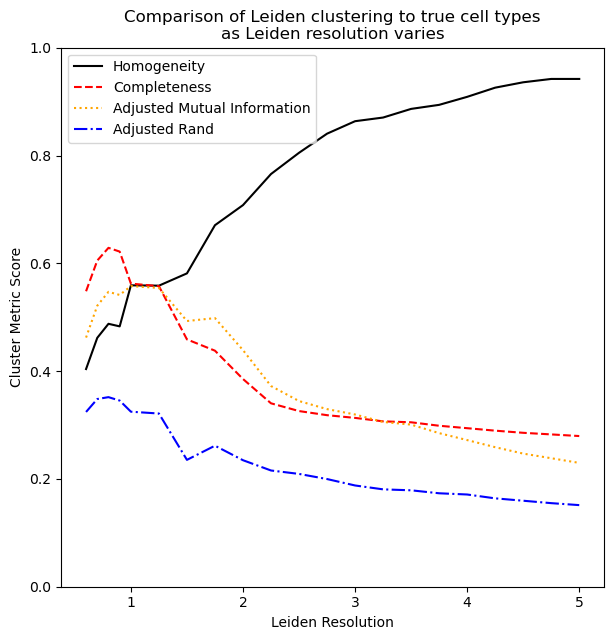

In [154]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(resolutions, results[:, 0], color='black', linestyle='-', label="Homogeneity")
ax.plot(resolutions, results[:, 1], color='red', linestyle='--', label="Completeness")
ax.plot(resolutions, results[:, 2], color='orange', linestyle=':', label="Adjusted Mutual Information")
ax.plot(resolutions, results[:, 3], color='blue', linestyle='-.', label="Adjusted Rand")

ax.legend(loc="upper left")
ax.set_xlabel("Leiden Resolution")
ax.set_ylabel("Cluster Metric Score")
ax.set_title("Comparison of Leiden clustering to true cell types\nas Leiden resolution varies")
ax.set_ylim([0, 1])

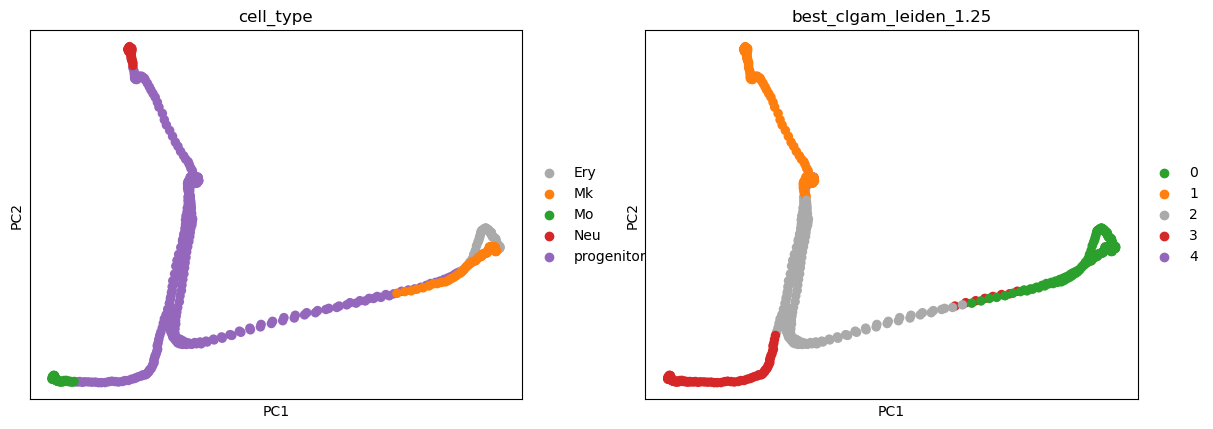

In [165]:
ordered_krum.uns["best_clgam_leiden_1.25_colors"] = ordered_krum.uns["cell_type_colors"][[2, 1, 0, 3, 4]]
sc.pl.pca(ordered_krum, color=["cell_type", "best_clgam_leiden_1.25"])

## Comparisons to using a single-axis (i.e. traditional LGAM)

In this section, we aim to find out if our method does any better than the most natural baseline of the standard LGAM model.  Because this only learns one graph, we'll devise two experiments:

1) Grid searching L1 and L2 to find the best gene MCC graph
2) A visual search over L2 parameters of the cell graph

In [196]:
traditional_lgam = []
l2regs = np.logspace(-2, 2.5, 10) / np.prod(dims)**(1/len(dims))
l1regs = np.logspace(0.5, -1.5, 10)
allregs = list(itertools.product(l2regs, l1regs))

for l2, l1 in allregs:
    dataset = ordered_krum.X.copy()
    dataset /= dataset.sum(axis=1).reshape(-1, 1)
    dims = dataset.shape
    L_init = [np.eye(d) for d in dims]

    glassoreg = glassoregs[sorting[2]]
    objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=l2, glassoregs=l1, sample_axes={0})

    Ls_out, (_, eps, _, _) = proximal_accelerated_gradient(
        f=objective,
        del_f=gradient,
        prox=proximal,
        P=project_to_lower_with_positive_diag,
        Ls=L_init,
        mu=0.2,
        init_alpha=1,
        tau=0.5,
        beta=0.0001,
        max_iter=1000,
        tol=1e-10,
        _delay_proximal_until=1
    )

    flat_genes = Ls_out[1][np.tril_indices(11, k=-1)] != 0
    flat_graph = ordered_truth.data[np.tril_indices(11, k=-1)] != 0
    mcc_ = matthews_corrcoef(flat_graph, flat_genes)
    traditional_lgam.append(mcc_)
    print(f"L1 Reg: {l1:.2e} \t L2 Reg: {l2:.2e} \t MCC: {mcc_:.4f}")

/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e+00 	 L2 Reg: 1.19e-04 	 MCC: 0.3423


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.90e+00 	 L2 Reg: 1.19e-04 	 MCC: 0.5508


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.14e+00 	 L2 Reg: 1.19e-04 	 MCC: 0.4738


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 6.81e-01 	 L2 Reg: 1.19e-04 	 MCC: 0.5897


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 4.08e-01 	 L2 Reg: 1.19e-04 	 MCC: 0.5245


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 2.45e-01 	 L2 Reg: 1.19e-04 	 MCC: 0.3376


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.47e-01 	 L2 Reg: 1.19e-04 	 MCC: 0.2377


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 8.80e-02 	 L2 Reg: 1.19e-04 	 MCC: 0.2377


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 5.27e-02 	 L2 Reg: 1.19e-04 	 MCC: 0.0943


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e-02 	 L2 Reg: 1.19e-04 	 MCC: 0.2115


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e+00 	 L2 Reg: 3.77e-04 	 MCC: 0.3423


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.90e+00 	 L2 Reg: 3.77e-04 	 MCC: 0.5508


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.14e+00 	 L2 Reg: 3.77e-04 	 MCC: 0.4738


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 6.81e-01 	 L2 Reg: 3.77e-04 	 MCC: 0.5897


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 4.08e-01 	 L2 Reg: 3.77e-04 	 MCC: 0.5245


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 2.45e-01 	 L2 Reg: 3.77e-04 	 MCC: 0.3376


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.47e-01 	 L2 Reg: 3.77e-04 	 MCC: 0.2377


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 8.80e-02 	 L2 Reg: 3.77e-04 	 MCC: 0.2377


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 5.27e-02 	 L2 Reg: 3.77e-04 	 MCC: 0.1113


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e-02 	 L2 Reg: 3.77e-04 	 MCC: 0.2115


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e+00 	 L2 Reg: 1.19e-03 	 MCC: 0.3423


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.90e+00 	 L2 Reg: 1.19e-03 	 MCC: 0.5508


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.14e+00 	 L2 Reg: 1.19e-03 	 MCC: 0.4738


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 6.81e-01 	 L2 Reg: 1.19e-03 	 MCC: 0.5897


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 4.08e-01 	 L2 Reg: 1.19e-03 	 MCC: 0.5245


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 2.45e-01 	 L2 Reg: 1.19e-03 	 MCC: 0.3376


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.47e-01 	 L2 Reg: 1.19e-03 	 MCC: 0.2377


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 8.80e-02 	 L2 Reg: 1.19e-03 	 MCC: 0.2377


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 5.27e-02 	 L2 Reg: 1.19e-03 	 MCC: 0.1113


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e-02 	 L2 Reg: 1.19e-03 	 MCC: 0.2115


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e+00 	 L2 Reg: 3.77e-03 	 MCC: 0.3423


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.90e+00 	 L2 Reg: 3.77e-03 	 MCC: 0.5508


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.14e+00 	 L2 Reg: 3.77e-03 	 MCC: 0.4738


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 6.81e-01 	 L2 Reg: 3.77e-03 	 MCC: 0.5897


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 4.08e-01 	 L2 Reg: 3.77e-03 	 MCC: 0.5245


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 2.45e-01 	 L2 Reg: 3.77e-03 	 MCC: 0.3376


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.47e-01 	 L2 Reg: 3.77e-03 	 MCC: 0.2377


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 8.80e-02 	 L2 Reg: 3.77e-03 	 MCC: 0.1550


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 5.27e-02 	 L2 Reg: 3.77e-03 	 MCC: 0.0675


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e-02 	 L2 Reg: 3.77e-03 	 MCC: 0.2115


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e+00 	 L2 Reg: 1.19e-02 	 MCC: 0.3423


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.90e+00 	 L2 Reg: 1.19e-02 	 MCC: 0.5508


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.14e+00 	 L2 Reg: 1.19e-02 	 MCC: 0.4738


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 6.81e-01 	 L2 Reg: 1.19e-02 	 MCC: 0.5897


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 4.08e-01 	 L2 Reg: 1.19e-02 	 MCC: 0.5245


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 2.45e-01 	 L2 Reg: 1.19e-02 	 MCC: 0.3376


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.47e-01 	 L2 Reg: 1.19e-02 	 MCC: 0.2377


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 8.80e-02 	 L2 Reg: 1.19e-02 	 MCC: 0.1784


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 5.27e-02 	 L2 Reg: 1.19e-02 	 MCC: 0.0831


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e-02 	 L2 Reg: 1.19e-02 	 MCC: 0.0358


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e+00 	 L2 Reg: 3.77e-02 	 MCC: 0.3423


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.90e+00 	 L2 Reg: 3.77e-02 	 MCC: 0.5508


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.14e+00 	 L2 Reg: 3.77e-02 	 MCC: 0.4738


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 6.81e-01 	 L2 Reg: 3.77e-02 	 MCC: 0.4738


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 4.08e-01 	 L2 Reg: 3.77e-02 	 MCC: 0.5245


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 2.45e-01 	 L2 Reg: 3.77e-02 	 MCC: 0.3912


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.47e-01 	 L2 Reg: 3.77e-02 	 MCC: 0.2249


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 8.80e-02 	 L2 Reg: 3.77e-02 	 MCC: 0.1446


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 5.27e-02 	 L2 Reg: 3.77e-02 	 MCC: 0.2102


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e-02 	 L2 Reg: 3.77e-02 	 MCC: 0.0747


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e+00 	 L2 Reg: 1.19e-01 	 MCC: 0.3423


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.90e+00 	 L2 Reg: 1.19e-01 	 MCC: 0.5508


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.14e+00 	 L2 Reg: 1.19e-01 	 MCC: 0.4738


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 6.81e-01 	 L2 Reg: 1.19e-01 	 MCC: 0.4892


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 4.08e-01 	 L2 Reg: 1.19e-01 	 MCC: 0.5245


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 2.45e-01 	 L2 Reg: 1.19e-01 	 MCC: 0.3912


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.47e-01 	 L2 Reg: 1.19e-01 	 MCC: 0.2377


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 8.80e-02 	 L2 Reg: 1.19e-01 	 MCC: 0.1920


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 5.27e-02 	 L2 Reg: 1.19e-01 	 MCC: 0.2581


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e-02 	 L2 Reg: 1.19e-01 	 MCC: 0.2554


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e+00 	 L2 Reg: 3.77e-01 	 MCC: 0.3423


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.90e+00 	 L2 Reg: 3.77e-01 	 MCC: 0.5508


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.14e+00 	 L2 Reg: 3.77e-01 	 MCC: 0.4738


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 6.81e-01 	 L2 Reg: 3.77e-01 	 MCC: 0.4738


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 4.08e-01 	 L2 Reg: 3.77e-01 	 MCC: 0.5245


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 2.45e-01 	 L2 Reg: 3.77e-01 	 MCC: 0.4450


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.47e-01 	 L2 Reg: 3.77e-01 	 MCC: 0.2602


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 8.80e-02 	 L2 Reg: 3.77e-01 	 MCC: 0.1685


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 5.27e-02 	 L2 Reg: 3.77e-01 	 MCC: 0.1377


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e-02 	 L2 Reg: 3.77e-01 	 MCC: 0.1644


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e+00 	 L2 Reg: 1.19e+00 	 MCC: 0.0000


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.90e+00 	 L2 Reg: 1.19e+00 	 MCC: 0.3855


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.14e+00 	 L2 Reg: 1.19e+00 	 MCC: 0.5124


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 6.81e-01 	 L2 Reg: 1.19e+00 	 MCC: 0.4242


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 4.08e-01 	 L2 Reg: 1.19e+00 	 MCC: 0.4461


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 2.45e-01 	 L2 Reg: 1.19e+00 	 MCC: 0.3735


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.47e-01 	 L2 Reg: 1.19e+00 	 MCC: 0.3622


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 8.80e-02 	 L2 Reg: 1.19e+00 	 MCC: 0.2361


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 5.27e-02 	 L2 Reg: 1.19e+00 	 MCC: 0.1895


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e-02 	 L2 Reg: 1.19e+00 	 MCC: 0.0358


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e+00 	 L2 Reg: 3.77e+00 	 MCC: 0.3936


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.90e+00 	 L2 Reg: 3.77e+00 	 MCC: 0.4486


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.14e+00 	 L2 Reg: 3.77e+00 	 MCC: 0.4614


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 6.81e-01 	 L2 Reg: 3.77e+00 	 MCC: 0.4738


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 4.08e-01 	 L2 Reg: 3.77e+00 	 MCC: 0.3941


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 2.45e-01 	 L2 Reg: 3.77e+00 	 MCC: 0.4450


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 1.47e-01 	 L2 Reg: 3.77e+00 	 MCC: 0.4075


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 8.80e-02 	 L2 Reg: 3.77e+00 	 MCC: 0.3418


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 5.27e-02 	 L2 Reg: 3.77e+00 	 MCC: 0.2959


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Reg: 3.16e-02 	 L2 Reg: 3.77e+00 	 MCC: 0.1299


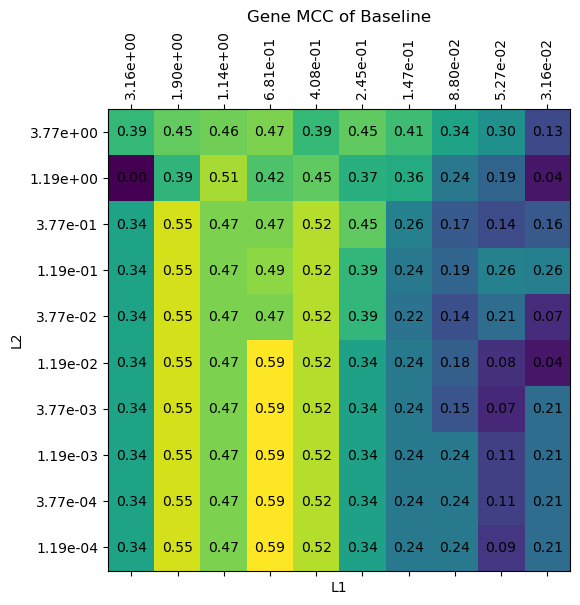

In [197]:
fig, ax = plt.subplots(figsize=(6, 6))

trad_mccs = np.array(traditional_lgam).reshape(10, 10)

ax.matshow(trad_mccs)
ax.set_xlabel("L1")
ax.set_ylabel("L2")
ax.set_title("Gene MCC of Baseline")
ax.set_xticks(np.arange(11)-1)
ax.set_xticklabels([''] + [f'{x:.2e}' for x in l1regs])
ax.set_yticks(np.arange(11)-1)
ax.set_yticklabels([''] + [f'{x:.2e}' for x in l2regs])
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.tick_params(axis='x', rotation=90)

for i in range(trad_mccs.shape[0]): # rows
    for j in range(trad_mccs.shape[1]): # columns
        text = ax.text(j, i, f"{trad_mccs[i, j]:.2f}",
                       ha="center", va="center", color="black")

In [198]:
best_l2, best_l1 = allregs[trad_mccs.reshape(-1).argmax()]

dataset = ordered_krum.X.copy()
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=best_l2, glassoregs=best_l1, sample_axes={0})

Ls_baseline, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    _delay_proximal_until=1
)

/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


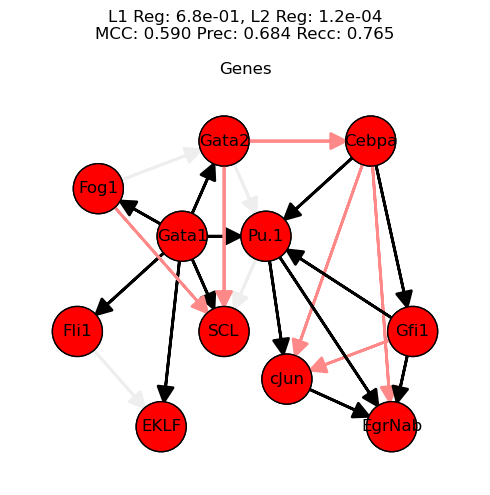

In [199]:
# It'll take a couple seconds to draw this graph.
fig, ax = plt.subplots(figsize=(5, 5), ncols=1)

random.seed(0)

# First, plot the 'true gene graph' to show false negatives
true_gene_graph = ig.Graph.Weighted_Adjacency(np.tril(ordered_truth, k=-1).T)
true_gene_graph.es["color"] = ['#eeeeee' for edge in true_gene_graph.es]
ig.plot(
    true_gene_graph,
    target=ax,
    vertex_size=50,
    layout=gene_layout,
)

gene_graph = ig.Graph.Weighted_Adjacency(Ls_baseline[1].T - np.diag(np.diag(Ls_baseline[1])))
gene_graph.vs["label"] = ordered_krum.var_names
#gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]
gene_graph.es["color"] = ['black' if ordered_truth.data[edge.target, edge.source] else '#ff8888' for edge in gene_graph.es]

ig.plot(
    gene_graph,
    target=ax,
    vertex_size=50,
    layout=gene_layout
)

ax.set_title("Genes")


flat_genes = Ls_baseline[1][np.tril_indices(11, k=-1)] != 0
flat_graph = ordered_truth.data[np.tril_indices(11, k=-1)] != 0
mcc_ = matthews_corrcoef(flat_graph, flat_genes)
prec_ = precision_score(flat_graph, flat_genes)
rec_ = recall_score(flat_graph, flat_genes)

fig.suptitle(
    f"L1 Reg: {best_l1:.1e}, L2 Reg: {best_l2:.1e}"
    + f"\nMCC: {mcc_:.3f}"
    + f" Prec: {prec_:.3f}"
    + f" Recc: {rec_:.3f}"
)
fig.tight_layout()
pass

TODOS:
1) Compare with single-axis method!